# Input Files for the Model
The notebook contains the code for generating input files for the running the idealized channel model. The files include analytical profiles of forcings, restoration and sponge. A generic topography is also generated.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

import initialization_functions as infs

$\large \text{Generate Mercator Grid}$

In isotropic mercator grid, all cell boxes are squares to reduce grid distortion. Here, the meridional grid spacing ($\Delta \phi$) decreases towards the poles as
$$\Delta \phi = \Delta \lambda \cos(\phi)$$
where $\Delta \lambda$ and $\phi$ are the zonal grid spacing (in degrees) and latitude, respectively.The resulting latitude traced points are given as (assuming j = 0 for equator),

$$\phi (j) = \frac{\pi}{180} \arcsin \left[\tanh(j\pi/180)\right]$$

Either use this code or read grid info from a file as in the code below

In [2]:
# Determine lat-lon tracer points
R_E = 6.378e6

lats, latn = (-70., -30.)
lonw, lone = (0., 80.)

res = 0.25  # Grid resolution
lon = np.arange(lonw + res/2., lone, res)

ind = np.arange(-397, -125); # indices for 0.25 deg resolution, adjust ind based on resolution

lat = (180/np.pi)*np.arcsin(np.tanh(res*np.pi*ind/180)) 

dlat = res * np.cos(lat * np.pi/180)
dlon = np.ones(len(lon)) * res

# Compute grid spacing in m
Long, Lati = np.meshgrid(lon, lat)
dx, dy = np.meshgrid(dlon, dlat)

dx = dx * np.cos(Lati * np.pi/180.) * (2*np.pi*R_E/360.)
dy = dy * (2*np.pi*R_E/360.)

In [3]:
DX = xr.DataArray(dx,coords=[("yh",lat), ("xh",lon)])
DY = xr.DataArray(dy,coords=[("yh",lat), ("xh",lon)])

X,Y = infs.calc_XYmeters_gen(DX.yh, DX.xh, DX, DY, 'yh', 'xh',center_x = True)

Text(0.5, 1.0, 'dy')

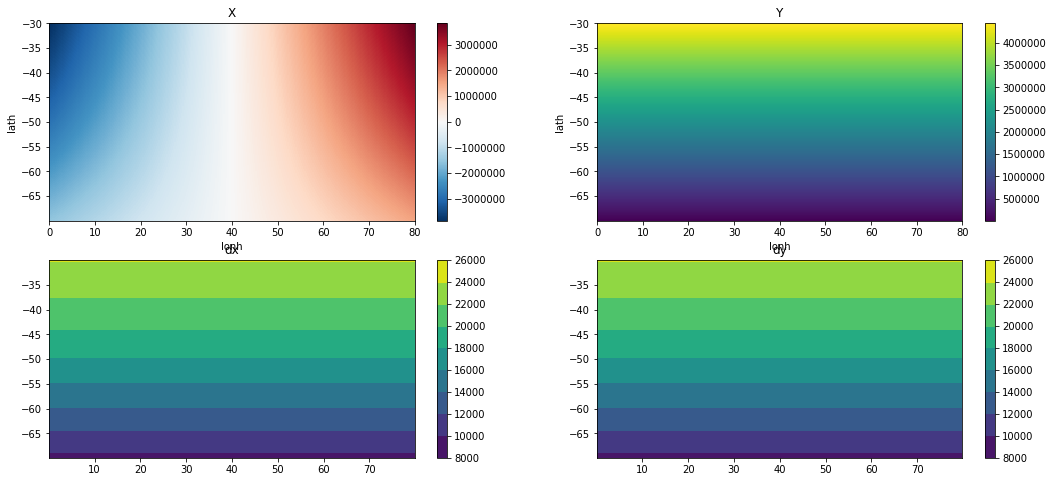

In [4]:
fig = plt.figure(figsize=[18,8])

plt.subplot(2,2,1)
X.plot()
plt.title('X')

plt.subplot(2,2,2)
Y.plot()
plt.title('Y')

plt.subplot(2,2,3)
plt.contourf(lon, lat, dx)
plt.colorbar()
plt.title('dx')

plt.subplot(2,2,4)
plt.contourf(lon, lat, dy)
plt.colorbar()
plt.title('dy')

$\large \text{Mosaic Grid}$

If mosaic grid option is chosen in MOM6, then grid coordinates (x ,y in deg.), grid spacings (dx, dy in meters) and cell areas (in m^2) need to be provided. These arrays contain both cell center and corner points; therefore, array sizes are (2 * Ny + 1, 2 * Nx + 1). The function below generates required arrays. 

Note - In isotropic mercator grid, zonal and meridional extent are not independent of number of grid points. The model may return error, if the the numbers are not consistet. In that case, supplying grid info may be an easier option.  

In [5]:
def grid_mosaic(lat, lon, dlat, dlon, R_E):
        
    Ny = lat.shape[0]
    Nx = lon.shape[0]
    
    # Number of points for arrays in the grid file
    nyp = 2*Ny + 1; nxp = 2*Nx + 1
    ny = 2*Ny; nx = 2*Nx
    
    # define arrays
    x1 = np.zeros([nyp, nxp])
    y1 = np.zeros([nyp, nxp])
    area1 = np.zeros([ny, nx])
    
    for i in range(0,nyp):
        x1[i,0:nxp-1:2] = lon - dlon/2.
        x1[i:,1::2] = lon
        x1[i,nxp-1] = lon[Nx-1] + dlon[Nx-1]/2.
    
    for i in range(0,nxp):
        y1[0:nyp-1:2,i] = lat - dlat/2.
        y1[1::2, i] = lat
        y1[nyp-1,i] = lat[Ny-1] + dlat[Ny-1]/2.
    
    dx1 = np.diff(x1,axis=1)
    dy1 = np.diff(y1,axis=0)
    
    dx1 = dx1 * np.cos(y1[:,0:nx] * np.pi/180.) * (2*np.pi*R_E/360.)
    dy1 = dy1 * (2*np.pi*R_E/360.)
    
    for j in range(0, ny):
        for i in range(0, nx):
            
            area1[j,i] = dx1[j,i] * dy1[j,i]
    
    grid = xr.Dataset()
    
    grid['x'] = xr.DataArray(x1,dims=['nyp','nxp'])
    grid['y'] = xr.DataArray(y1,dims=['nyp','nxp'])
    grid['dx'] = xr.DataArray(dx1,dims=['nyp','nx'])
    grid['dy'] = xr.DataArray(dy1,dims=['ny','nxp'])
    grid['area'] = xr.DataArray(area1,dims=['ny','nx'])
    
    return grid

In [6]:
grid = grid_mosaic(lat, lon, dlat, dlon, R_E)

grid.to_netcdf('../../MOM6_PEM_INPUT/Shelf_Kerguelen_25/hgrid'+'.nc')

In [7]:
grid

<xarray.Dataset>
Dimensions:  (nx: 640, nxp: 641, ny: 544, nyp: 545)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x        (nyp, nxp) float64 0.0 0.125 0.25 0.375 ... 79.62 79.75 79.88 80.0
    y        (nyp, nxp) float64 -69.98 -69.98 -69.98 ... -29.92 -29.92 -29.92
    dx       (nyp, nx) float64 4.764e+03 4.764e+03 ... 1.206e+04 1.206e+04
    dy       (ny, nxp) float64 4.773e+03 4.773e+03 ... 1.205e+04 1.205e+04
    area     (ny, nx) float64 2.274e+07 2.274e+07 ... 1.451e+08 1.451e+08

$\large \text{Read lat-lon grid data}$

This is to read grid information from static file generated through a global ocean run. This is an alternative method than the above.

In [8]:
#ds = xr.open_dataset('../../ocean_monthly_z.static.nc') 

#ds

In [9]:
# Define lat and lon limits for the domain
#lat = ds['yh'].sel(yh = slice(-70.,-30))
#lon = ds['xh'].sel(xh = slice(-280.,-200.)) + 280. # set lon extent to (0, 80.)
#dx = ds['dxt'].sel(xh = slice(-280.,-200.), yh = slice(-70.,-30.))
#dy = ds['dyt'].sel(xh = slice(-280.,-200.), yh = slice(-70.,-30.))

#X,Y = infs.calc_XYmeters_gen(lat, lon, dx, dy, 'yh', 'xh',center_x = True)

In [10]:
#fig = plt.figure(figsize=[18,8])

#plt.subplot(2,2,1)
#X.plot()
#plt.title('X')

#plt.subplot(2,2,2)
#Y.plot()
#plt.title('Y')

#plt.subplot(2,2,3)
#dx.plot()
#plt.title('dx')

#plt.subplot(2,2,4)
#dy.plot()
#plt.title('dy')

$\large \text{Vertical grid and layer densities} $

In [11]:
# Vertical grid
nk = 75
max_depth = 4000.
min_depth = 0.
thkcello_topcell = 1.
method = 'powerlaw'

vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,
                        thkcello_topcell=thkcello_topcell,method=method)

density = xr.open_dataset('../../hycom1_75_800m.nc')
sigma2 = xr.DataArray(density.sigma2.values,coords=[vgrid['NKp1']],dims=['NKp1'])

vgrid = xr.merge([vgrid, sigma2.rename("sigma2")])

#vgrid.to_netcdf('../../MOM6_PEM_INPUT/Shelf_Kerguelen_25/vgrid'+'.nc')

In [12]:
vgrid

<xarray.Dataset>
Dimensions:  (NK: 75, NKp1: 76)
Coordinates:
  * NKp1     (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
  * NK       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
Data variables:
    zw       (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
    zt       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
    dz       (NK) float64 1.0 2.787 4.465 6.089 ... 98.04 99.31 100.6 101.8
    sigma2   (NKp1) float64 1.01e+03 1.014e+03 1.018e+03 ... 1.038e+03 1.038e+03

$\large \text{Surface Forcing Files}$ 

Zonally uniform forcing profiles are created for wind stress and surface fluxes. These profiles inspired from SOSEE dataset (see SOSE_Forcing notebook). The general form of the function is
$$f(y) = \sin\left(y + \frac{b}{2}\sin(a\cdot y)\right)^c$$
a, b, c coefficients control the shape and skewness of the profile. Recommended values are a = 1 or 2; b = [-1, 1] and c = 1 or 2.

In [18]:
# Wind Forcing

sponge_width = 1. # In degrees

taux_east = 0.18
taux_west = 0.08
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 63.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = (np.max(Y.isel(lonh=0).values) - 
          Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) + sponge_width).argmin()).values)

wind = xr.Dataset()
wind['taux'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = taux_east, 
                                 max_south = taux_west, a=1., b=0.9, c=1., d=1., e=0, f=2.)

wind['tauy'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = 0., 
                                 max_south = 0., a=1., b=0.9, c=1., d=1., e=0, f=2.)

# Save
wind = wind.transpose('lath','lonh')
#wind.to_netcdf('../../MOM6_PEM_INPUT/Shelf_Kerguelen_25/wind'+'.nc')

Buoyancy forcing is set to zero in the code below but, similar to the zonal wind stress profile, the buoyancy forcing terms can be set to have nonzero values. 

In [12]:
# Surface Fluxes

buoyancy = xr.Dataset()
buoyancy['LW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['SW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['sensible'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['latent'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['evap'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

# Save
buoyancy = buoyancy.transpose('lath','lonh')
buoyancy.to_netcdf('../../MOM6_PEM_INPUT/Shelf_Kerguelen_25/buoyancy'+'.nc')

This model setup for an equation of state of single variable only, i.e. density is a function of temperature only. Salinity is set to be uniform in the domain. 

In [8]:
# Temperature and salinity initial conditions
Tn = 22
Ts = 0
Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 43.0).argmin()).values
Ws = 1.e6

TS = xr.Dataset()
TS['SST'] = infs.calc_distribution(coordinate = Y, function='tan_hyperbolic', val_at_maxcoord = Tn, 
                                   val_at_mincoord = Ts, Ys = Ys, Ws = Ws)

Sn = 35.
Ss = 35.
Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 43.0).argmin()).values
Ws = 2.5e5

TS['SSS'] = infs.calc_distribution(coordinate = Y, function='uniform',uniform_value = Sn)

# Extend temperature and salinity in the vertical
TS['T'] = (infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', val_at_maxcoord = TS['SST'], efolding = 800))

#+ infs.calc_distribution(coordinate=-vgrid.zt, function = 'linear', val_at_maxcoord = TS['SST']*0.05, val_at_mincoord = TS['SST']*0.025)) 

#TS['S'] = infs.calc_distribution(coordinate=-vgrid.zt,function='uniform',uniform_value = Sn)
TS['S'] = TS['T']*0 + Ss

z1 = vgrid['zw'].values
z1 = np.delete(z1, nk-1)

#TS['DEPTH'] = (('NK'), z1) # This is required for INIT_FROM_Z in MOM6
#TS['LAT'] = TS.lath
#TS['LON'] = TS.lonh

TS = TS.transpose('NK','lath','lonh')
#TS.to_netcdf('../../MOM6_PEM_INPUT/Shelf_Kerguelen_25/TS'+'.nc')

In order to use "INIT_LAYERS_FROM_Z_FILE" option, the input variables needs to be in spcific format and some variable names are also fixed. Follow the method as used below to generate input file. Note that vertical grid in input file need not be the same and can have different grid points in the vertical than in the model configuration. MOM6 would interpolate data on the model coordinate.  

In [31]:
TS_Z_init = TS.rename({'lonh': 'LON','lath': 'LAT','NK': 'DEPTH'})
TS_Z_init = TS_Z_init.drop(['SSS', 'SST'])
TS_Z_init = TS_Z_init.expand_dims({"TIME":np.array([0.])})

In [32]:
TS_Z_init.T.attrs['units'] = "Celsius"
TS_Z_init.T.attrs['standard_name'] = "Initial potential temperature referenced to 0dbar"
TS_Z_init.T.attrs['_FillValue'] = -1.e34
TS_Z_init.T.attrs['missing_value'] = -1.e34

TS_Z_init.S.attrs['units'] = "PSU"
TS_Z_init.S.attrs['standard_name'] = "Initial salinity"
TS_Z_init.S.attrs['_FillValue'] = -1.e34
TS_Z_init.S.attrs['missing_value'] = -1.e34

TS_Z_init.DEPTH.attrs['units'] = "m"
TS_Z_init.DEPTH.attrs['standard_name'] = "Z coordinate"
TS_Z_init.DEPTH.attrs['cartesian_axis'] = "Z"
TS_Z_init.DEPTH.encoding['_FillValue'] = False

TS_Z_init.LON.attrs['units'] = "degrees_east"
TS_Z_init.LON.attrs['cartesian_axis'] = "X"
TS_Z_init.LON.encoding['_FillValue'] = False

TS_Z_init.LAT.attrs['units'] = "degrees_north"
TS_Z_init.LAT.attrs['cartesian_axis'] = "Y"
TS_Z_init.LAT.encoding['_FillValue'] = False

TS_Z_init.TIME.attrs['units'] = "days since 0001-01-01 00:00:00"
TS_Z_init.TIME.attrs['calendar'] = "noleap"
TS_Z_init.TIME.attrs['cartesian_axis'] = "T"
TS_Z_init.TIME.encoding['_FillValue'] = False

In [34]:
TS_Z_init
TS_Z_init.to_netcdf('../../MOM6_PEM_INPUT/Shelf_Kerguelen_25/TS_init_Z'+'.nc')

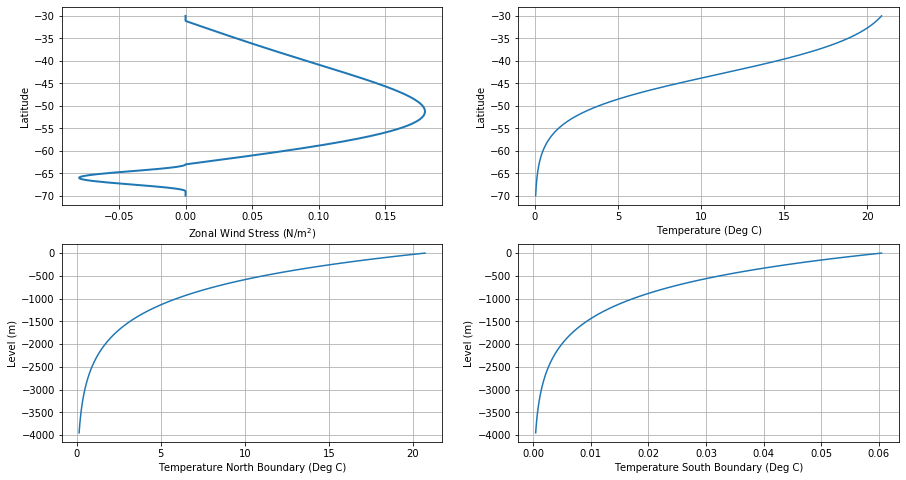

In [16]:
fig = plt.figure(figsize=[15,8])

plt.subplot(2,2,1)
plt.plot(wind['taux'].isel(lonh=0), wind['lath'],lw=2)
plt.grid()
plt.xlabel('Zonal Wind Stress (N/m$^2$)')
plt.ylabel('Latitude')

plt.subplot(2,2,2)
plt.plot(TS['SST'].isel(lonh=0),TS.lath)
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Latitude')
plt.grid()

plt.subplot(2,2,3)
plt.plot(TS['T'].isel(lonh=0).sel(lath=slice(-31,-30)).mean('lath'),-TS.NK)
plt.xlabel('Temperature North Boundary (Deg C)')
plt.ylabel('Level (m)')
plt.grid()

plt.subplot(2,2,4)
plt.plot(TS['T'].isel(lonh=0).sel(lath=slice(-70,-69)).mean('lath'),-TS.NK)
plt.xlabel('Temperature South Boundary (Deg C)')
plt.ylabel('Level (m)')
plt.grid()

In [16]:
# Sponge region
sponge_width = [100E3,50E3] # In Sponge, wind stress must be zero
#sponge_width = [sp_width, sp_width/2.] # This is the sponge in wind stress file
idampval=[1/(7*86400),1/(7*86400)] # Relaxation of 7 days in 100 km width at the northern boundary

sponge = xr.Dataset()
sponge['idamp'] = infs.def_sponge_dampingtimescale_north(Y,sponge_width=sponge_width,idampval=idampval)
sponge['eta'] = infs.def_sponge_interfaceheight(vgrid,Y)

# Add temperature and salinity profile to sponge region
sponge['T'] = TS['T']
sponge['S'] = TS['S']

sponge = sponge.transpose('NKp1','NK','lath','lonh')
sponge.to_netcdf('../../MOM6_PEM_INPUT/Shelf_Kerguelen_25/sponge'+'.nc')

In [57]:
# Topography
max_depth = 4000.

Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 66.5).argmin()).values
min_shelf_depth, shelf_lat, shelf_width = (500., Ys, 1.e5)

d_shelf = (infs.make_topography(function='shelf', H=max_depth, Hs=min_shelf_depth, Y1=Y, 
                                Ys=shelf_lat, Ws=shelf_width))

bump_lat = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 52.).argmin()).values
bump_lon = X.isel(lonh = 120)
bump_width = np.abs(Y.isel(lonh =0, lath = np.abs(Y.lath.values + 46.).argmin()).values -
                    Y.isel(lonh =0, lath = np.abs(Y.lath.values + 58.).argmin()).values)
bump_length = np.abs(X.isel(lath =0, lonh = np.abs(X.lonh.values - 30.).argmin()).values -
                    X.isel(lath =0, lonh = np.abs(X.lonh.values - 50.).argmin()).values)

d_bump = (infs.make_topography(function='bump', Hs=3000., Y1=Y, X1=X, Wx=bump_length, Wy=bump_width,
                              Xs=bump_lon, Ys=bump_lat, dx=2.0, dy=2.0))

topography = xr.Dataset()
height = np.maximum(-d_shelf, d_bump)
topography['depth'] = -1*(-max_depth + height)

topography.transpose('lath','lonh')
topography.to_netcdf('../topography'+'.nc')

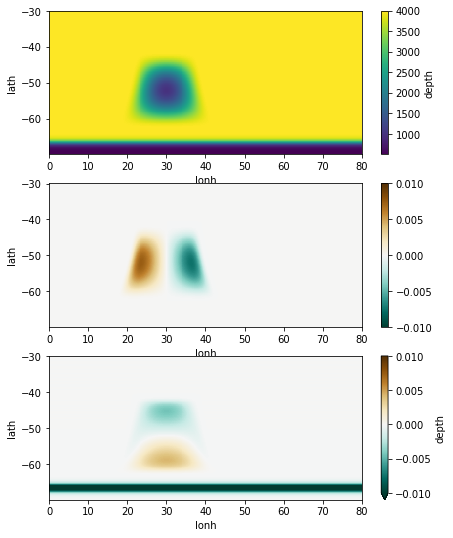

In [58]:
# Topography is a combination of bump (inspired from Kerguelen plateou) and continetal shelf. 
# Topographic gradient magnitudes are close to reality

grady = - topography['depth'].differentiate("lath")*360/(2*np.pi*6378100)
gradx = - topography['depth'].differentiate("lonh")*360/(2*np.pi*6378100*np.cos(Y.lath*np.pi/180.))

fig = plt.figure(figsize=[7,9])

plt.subplot(3,1,1)
topography.depth.plot()

plt.subplot(3,1,2)
gradx.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

plt.subplot(3,1,3)
grady.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

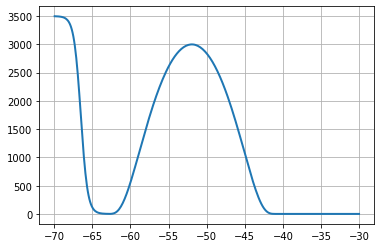

In [59]:
plt.plot(topography['lath'], 4000. - topography['depth'].isel(lonh=120),lw=2)
#plt.plot(Y.isel(lonh=120)/1000., 4000. - topography['depth'].isel(lonh=120),lw=2)
plt.grid()